In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter
import os
from os import path 
import h5py
import sys
import Initialize_Paths as Paths

# Import Reading Functions
sys.path.insert(0, Paths.Surqct_path  + '/surqct/scripts/Paper_figures/')
from Reading import read_diatdata, read_HDF5, read_pops

In [2]:
pd.set_option('display.max_columns', None)  
sns.set_style('ticks')
plt.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \boldmath']
# plt.rc('text.latex', preamble=r'\usepackage{pifont} \usepackage{tikz} \usepackage[utf8]{inputenc}')
plt.rc('font', family='Times')
sns.set_context("paper")

# Tick parameters
plt.rcParams['xtick.labelsize'] = 40
plt.rcParams['ytick.labelsize'] = 40
mpl.rcParams['xtick.major.size'] = 20
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.size'] = 10
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 20
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 10
mpl.rcParams['ytick.minor.width'] = 2

plt.rcParams['axes.labelsize'] = 40
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['legend.fontsize'] = 35

<ipython-input-2-cf7c5584ff04>:4: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \boldmath']


# Initializing Run 

In [3]:
SystName    = 'N3_NASA'
# Dimension   = 'prode'
Dimension   = 'nondim_N3'
InelRunNb   = 8
ExchRunNb   = 2
DissRunNb   = 55
TransInelRunNb    = 42
TransExchRunNb    = 8
ReactionFlgQCT    = '0_1_1_0'
ReactionFlgSurQCT = '0_1_1_0'
TauReactionFlgQCT    = '0_1_1_0'
TauReactionFlgSurQCT = '0_1_1_0'
TempVec = [5000, 10000, 20000]
PopPlotTime = [1e-6]

# Initializing System

In [4]:
import Initialize_System
Initialize = getattr(Initialize_System,'Initialize_'+SystName)
System = Initialize()

# Initializing Paths

In [5]:
QCT_ME_path    = Paths.Workspace_path + 'Air_Database/' + System.QCTMEPath
SurQCT_ME_path = Paths.Workspace_path + 'Air_Database/Run_0D_surQCT/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'

Data_ME_path   = Paths.Surqct_path + '0D/Data/' + System.Name + '/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'
Figure_ME_path = Paths.Surqct_path + '0D/Figures/' + System.Name + '/' + Dimension + '_RunI'+str(InelRunNb)+'_E'+str(ExchRunNb)+'_D'+str(DissRunNb)+'/'

# For N3 only
# Transfer_Data_ME_path   = Paths.Surqct_path + '0D/Data/' + System.Name + '/transfer_RunI'+str(TransInelRunNb)+'_E'+str(TransExchRunNb)+'_D'+str(DissRunNb)+'/'
# Transfer_Figure_ME_path = Paths.Surqct_path + '0D/Figures/' + System.Name + '/transfer_RunI'+str(TransInelRunNb)+'_E'+str(TransExchRunNb)+'_D'+str(DissRunNb)+'/'

try:
    os.makedirs(Data_ME_path)
except OSError as e:
    pass

try:
    os.makedirs(Figure_ME_path)
except OSError as e:
    pass

print('QCT Master Equation Path    :', QCT_ME_path)
print('SurQCT Master Equation Path :', SurQCT_ME_path)
print('Data Master Equation Path   :', Data_ME_path)
print('Figures Master Equation Path:', Figure_ME_path)

QCT Master Equation Path    : /home/venturi/WORKSPACE/Air_Database/Run_0D_semi/
SurQCT Master Equation Path : /home/venturi/WORKSPACE/Air_Database/Run_0D_surQCT/nondim_N3_RunI8_E2_D55/
Data Master Equation Path   : /home/venturi/WORKSPACE/SurQCT/0D/Data/N3_NASA/nondim_N3_RunI8_E2_D55/
Figures Master Equation Path: /home/venturi/WORKSPACE/SurQCT/0D/Figures/N3_NASA/nondim_N3_RunI8_E2_D55/


# Read Diatomic Properties and Rates

In [6]:
# Read Diatomic Potentials
DiatData   = []

for iMol in range(System.NMolecules):
    DiatDataTemp = read_diatdata(System.PathToDiatFile[iMol], System.Molecule[iMol].Name, TempVec)
    DiatData.append(DiatDataTemp)
    System.Molecule[iMol].NLevels = np.size(DiatData[iMol]['EInt'].to_numpy())

Temp = TempVec[0]
# # Read Rates
# PathToHDF5File = System.PathToHDF5Fld+System.Name+'.hdf5'
# System = read_HDF5(System, PathToHDF5File, Temp, Temp)


[HCN]:   Reading Molecular Levels Data from: /home/venturi/WORKSPACE/CoarseAIR/coarseair/dtb/Molecules/N2/LeRoy/MyLeroy_FromRobyn.inp


# Reading Master Equation Solution Files

In [7]:
QCT=[]
SurQCT=[]
PopQCT = []
PopSurQCT = []

for iTemp in range(len(TempVec)):

    Temp = TempVec[iTemp]
    
    # QCT
    FileName=QCT_ME_path+'output_'+System.Name+'_T'+str(Temp)+'K_'+ReactionFlgQCT+'/box.dat'
    QCTTemp=pd.read_csv(FileName,delimiter='  ')
    QCTTemp.columns = System.Box_Header
    QCT.append(QCTTemp)
    QCT[iTemp].NSteps = np.size(QCT[iTemp]['time'].to_numpy()) 

    PopFilePath=QCT_ME_path+'output_'+System.Name+'_T'+str(Temp)+'K_'+ReactionFlgQCT
    PopTempQCT=read_pops(PopFilePath,System,DiatData,QCT[iTemp].time)
    PopQCT.append(PopTempQCT)

    # SurQCT
    FileName=SurQCT_ME_path+'output_'+System.Name+'_T'+str(Temp)+'K_'+ReactionFlgSurQCT+'/box.dat'
    SurQCTTemp=pd.read_csv(FileName,delimiter='  ')
    SurQCTTemp.columns = System.Box_Header
    SurQCT.append(SurQCTTemp)
    SurQCT[iTemp].NSteps = np.size(SurQCT[iTemp]['time'].to_numpy()) 
    
    PopFilePath=SurQCT_ME_path+'output_'+System.Name+'_T'+str(Temp)+'K_'+ReactionFlgSurQCT
    PopTempSurQCT=read_pops(PopFilePath,System,DiatData,SurQCT[iTemp].time)
    PopSurQCT.append(PopTempSurQCT)

<ipython-input-7-a99c3ce92033>:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  QCTTemp=pd.read_csv(FileName,delimiter='  ')


[Master Equation]:   Reading Population Data from: /home/venturi/WORKSPACE/Air_Database/Run_0D_semi/output_N3_NASA_T5000K_0_1_1_0


/home/venturi/WORKSPACE/SurQCT//surqct/scripts/Paper_figures/Reading.py:102: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  Pop=pd.read_csv(FileName,sep="   ",skiprows=2,header=None,index_col=False,comment='&')
/home/venturi/WORKSPACE/SurQCT//surqct/scripts/Paper_figures/Reading.py:105: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  Pop.Pop_g = np.reshape(Pop.PopTemp.to_numpy(),(np.size(time)+1,System.Molecule[0].NLevels))
/home/venturi/WORKSPACE/SurQCT//surqct/scripts/Paper_figures/Reading.py:106: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  Pop.Pop = DiatData[

[Master Equation]:   Reading Population Data from: /home/venturi/WORKSPACE/Air_Database/Run_0D_surQCT/nondim_N3_RunI8_E2_D55/output_N3_NASA_T5000K_0_1_1_0
[Master Equation]:   Reading Population Data from: /home/venturi/WORKSPACE/Air_Database/Run_0D_semi/output_N3_NASA_T10000K_0_1_1_0
[Master Equation]:   Reading Population Data from: /home/venturi/WORKSPACE/Air_Database/Run_0D_surQCT/nondim_N3_RunI8_E2_D55/output_N3_NASA_T10000K_0_1_1_0
[Master Equation]:   Reading Population Data from: /home/venturi/WORKSPACE/Air_Database/Run_0D_semi/output_N3_NASA_T20000K_0_1_1_0
[Master Equation]:   Reading Population Data from: /home/venturi/WORKSPACE/Air_Database/Run_0D_surQCT/nondim_N3_RunI8_E2_D55/output_N3_NASA_T20000K_0_1_1_0


# Compute

In [8]:
# from Compute import compute_energy

# for iTemp in range(len(TempVec)):

#     Temp = TempVec[iTemp]
#     QCT[iTemp].eRot, QCT[iTemp].eVib = compute_energy(System, PopQCT[iTemp].Pop, DiatData, QCT[iTemp])
#     SurQCT[iTemp].eRot, SurQCT[iTemp].eVib = compute_energy(System, PopSurQCT[iTemp].Pop, DiatData, SurQCT[iTemp])


# from Compute import compute_energy
from scipy.interpolate import CubicSpline
from scipy.optimize import root_scalar, fsolve

def compute_energy(System,Pop,DiatData,Run):
    # Energy computation
    eRot=np.zeros(Run.NSteps)
    eVib=np.zeros(Run.NSteps)
    NSteps = Run.NSteps
    time = SurQCT[0]['time']
    
    #    for iMol in range(len(System.Molecule)):
    iMol = 0
    for iStep in range(0,Run.NSteps):
        Ni = Pop[iStep,:]
        NiTot = np.sum(Ni)   
        eRot[iStep] = sum( DiatData[iMol]['ERot']*Ni ) / NiTot
        eVib[iStep] = sum( DiatData[iMol]['EVibv0Ref']*Ni ) / NiTot
    
    tauVib_calculated = 1e-8
    tauRot_calculated = 1e-8

#     # Compute TauRot
#     eRotLim = (eRot[NSteps-1] - eRot[1]) * 0.632 + eRot[1];
#     TempCoeff = 0;
#     if(eRot[NSteps-1] < eRot[1]):
#         TempCoeff = -1;
#     iRot=2;
#     while (TempCoeff*eRot[iRot] < TempCoeff*eRotLim and (iRot<NSteps-1)):
#         iRot = iRot+1;

#     tauRot = (time[iRot] + time[iRot-1])/2.0
#     xData = time[2:NSteps-2]
#     yData = eRot[2:NSteps-2] - eRotLim
#     Taus = CubicSpline(xData, yData)
#     tauRot_calculated = fsolve(Taus,[tauRot]) 
# #     tauRot_calculated = fsolve(Taus,[4.6997736e-09]) 
    
#     # Compute TauVib
#     eVibLim = (eVib[NSteps-1] - eVib[1]) * 0.632 + eVib[1];
#     TempCoeff = 0;
#     if(eVib[NSteps-1] < eVib[1]):
#         TempCoeff = -1;
#     iVib=2;
#     while (TempCoeff*eVib[iVib] < TempCoeff*eVibLim and (iVib<NSteps-1)):
#         iVib = iVib+1;

#     tauVib = (time[iVib] + time[iVib-1])/2.0
#     xData = time[2:NSteps-2]
#     yData = eVib[2:NSteps-2] - eVibLim
#     Taus = CubicSpline(xData, yData)
    
#     tauVib_calculated = fsolve(Taus,[tauVib]) 
#     tauVib_calculated = fsolve(Taus,[2.06724422e-08]) 
    
    return eRot, eVib, tauRot_calculated, tauVib_calculated


QCTTaus = pd.DataFrame()
SurQCTTaus = pd.DataFrame()

for iTemp in range(len(TempVec)):

    Temp = TempVec[iTemp]
    QCT[iTemp].eRot, QCT[iTemp].eVib, QCT[iTemp].tauRot, QCT[iTemp].tauVib = compute_energy(System, PopQCT[iTemp].Pop, DiatData, QCT[iTemp])
    SurQCT[iTemp].eRot, SurQCT[iTemp].eVib, SurQCT[iTemp].tauRot, SurQCT[iTemp].tauVib = compute_energy(System, PopSurQCT[iTemp].Pop, DiatData, SurQCT[iTemp])
    
#     QCT[iTemp].tauVibP = QCT[iTemp].tauVib*QCT[iTemp].Pressure.iloc[-1]/101325.0*QCT[iTemp].N.iloc[-1]
#     SurQCT[iTemp].tauVibP = SurQCT[iTemp].tauVib*SurQCT[iTemp].Pressure.iloc[-1]/101325.0*SurQCT[iTemp].N.iloc[-1]
    
#     QCT[iTemp].tauRotP = QCT[iTemp].tauRot*QCT[iTemp].Pressure.iloc[-1]/101325.0*QCT[iTemp].N.iloc[-1]
#     SurQCT[iTemp].tauRotP = SurQCT[iTemp].tauRot*SurQCT[iTemp].Pressure.iloc[-1]/101325.0*SurQCT[iTemp].N.iloc[-1]
    
#     QCTPressure = QCT[iTemp].Pressure.iloc[-1]/101325.0
#     SurQCTPressure = SurQCT[iTemp].Pressure.iloc[-1]/101325.0
    
# #     print(QCT[iTemp].tauRotP, QCT[iTemp].tauVibP, SurQCT[iTemp].tauRotP, SurQCT[iTemp].tauVibP)
#     QCTTaus['Temp'] = Temp
#     QCTTaus['Pressure'] = QCTPressure
#     QCTTaus['TauRot'] = QCT[iTemp].tauRotP 
#     QCTTaus['TauVib'] = QCT[iTemp].tauVibP
    
#     SurQCTTaus['Temp'] = Temp
#     SurQCTTaus['Pressure'] = SurQCTPressure
#     SurQCTTaus['TauRot'] = SurQCT[iTemp].tauRotP 
#     SurQCTTaus['TauVib'] = SurQCT[iTemp].tauVibP
    
#     file = Data_ME_path + '/QCT_Taus_' +  System.Molecule[0].Name +'_'+ReactionFlgQCT+'.csv'
#     QCTTaus.to_csv(file,mode='a',index=False,header=False)
#     file = Data_ME_path + '/DNN_Taus_' +  System.Molecule[0].Name +'_'+ReactionFlgQCT+'.csv'
#     SurQCTTaus.to_csv(file,mode='a',index=False,header=False)
    

<ipython-input-8-7d515540b8b8>:74: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  QCT[iTemp].eRot, QCT[iTemp].eVib, QCT[iTemp].tauRot, QCT[iTemp].tauVib = compute_energy(System, PopQCT[iTemp].Pop, DiatData, QCT[iTemp])
<ipython-input-8-7d515540b8b8>:75: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  SurQCT[iTemp].eRot, SurQCT[iTemp].eVib, SurQCT[iTemp].tauRot, SurQCT[iTemp].tauVib = compute_energy(System, PopSurQCT[iTemp].Pop, DiatData, SurQCT[iTemp])


# Plots

In [10]:
# Mole fraction Plot                                                                                                                         
def Plot_MoleFraction_allTemp(System,QCT,SurQCT,TempVec,MoleFractionXLim):                                                                           
            
    MoleculeName = System.Molecule[0].Name
    fig,ax = plt.subplots(1,1,figsize=(10,10))   
    plt.plot(QCT[0].time, QCT[0][MoleculeName], '-k', label='\\textbf{QCT}',linewidth=5)                                                                     
    plt.plot(SurQCT[0].time, SurQCT[0][MoleculeName], '-r', label='\\textbf{SurQCT}',linewidth=5) 
    
    for iTemp in range(len(TempVec)):                                                                                                                                                                                                           
        plt.plot(QCT[iTemp].time, QCT[iTemp][MoleculeName], '-k', linewidth=5)                                                                     
        plt.plot(SurQCT[iTemp].time, SurQCT[iTemp][MoleculeName], '-r', linewidth=5)                                                            
                                                                                                                                             
#     plt.legend(frameon=False,bbox_to_anchor=(0.5, 0.78))
    plt.legend()
    plt.xscale('log')                                                                                                                     
    plt.xlabel('\\textbf{t [s]}')                                                                                                            
    plt.ylabel('\\textbf{X}')                                                                                                                
    plt.xlim(MoleFractionXLim)                                                                                                               
    ax.xaxis.set_minor_locator(AutoMinorLocator())                                                                                           
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')  
#     ax.set_xticks([1.e-9,1.e-8,1.e-7,1.e-6,1.e-5,1e-4,1e-3])
    fig.tight_layout(pad=0.75)                                                                                                                
                                                                                                                                             
    return fig


In [10]:
# Energy evolution plot                                                                                                                        
def Plot_Energies(System,QCT,SurQCT,TempVec,EnergyXLim):                                                                                       
                                                                                                                                               
    iTemp = 0                                                                                                                                  
    fig,ax = plt.subplots(1,1,figsize=(10,10))                                                                                                 
    plt.plot(QCT[iTemp].time, QCT[iTemp].eRot,'--k', label='\\textbf{ERot}',linewidth=3)                                                       
    plt.plot(QCT[iTemp].time, QCT[iTemp].eVib, '-k', label='\\textbf{EVib}',linewidth=3)                                                       
                                                                                                                                               
    for iTemp in range(len(TempVec)):                                                                                                          
                                                                                                                                               
        Temp = TempVec[iTemp]                                                                                                                  
                                                                                                                                               
        plt.plot(QCT[iTemp].time, QCT[iTemp].eRot,'--k', linewidth=3)                                                                          
        plt.plot(QCT[iTemp].time, QCT[iTemp].eVib, '-k', linewidth=3)                                                                          
                                                                                                                                               
        plt.plot(SurQCT[iTemp].time, SurQCT[iTemp].eRot, color='red', linestyle='dashed', linewidth=5)                                         
        plt.plot(SurQCT[iTemp].time, SurQCT[iTemp].eVib, color='red',linestyle='-', linewidth=5)                                               
                                                                                                                                               
        plt.legend()                                                                                                              
        plt.xscale('log')                                                                                                                      
        plt.xlabel('\\textbf{t [s]}')                                                                                                          
        plt.ylabel('\\textbf{E [eV]}')                                                                                                         
        plt.xlim(EnergyXLim)                                                                                                          
        ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')                                                                               
        fig.tight_layout(pad=0.75)                                                                                                             
        plt.savefig((Figure_ME_path+System.Name+'_'+ReactionFlgSurQCT+'_T'+str(Temp)+'K_Energy.pdf'), format='pdf', dpi=600)                   
                                                                                                                                               
    return fig

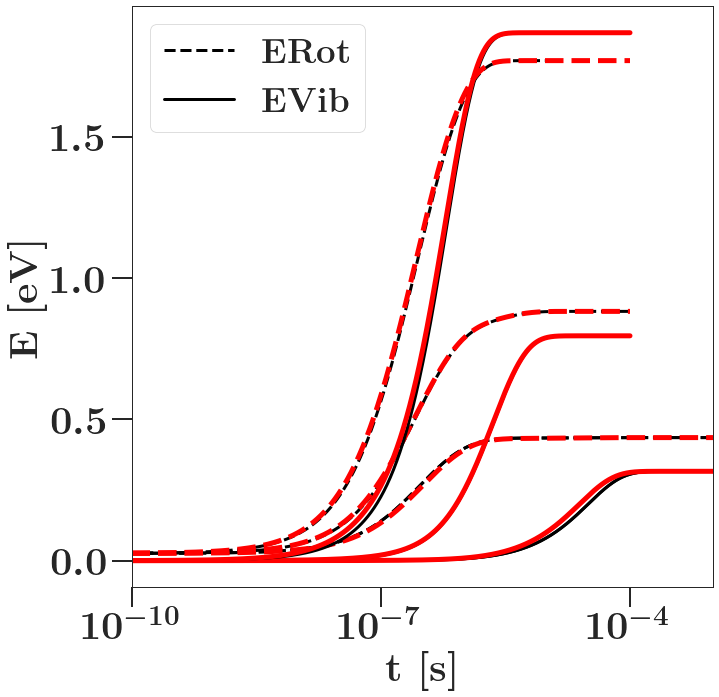

In [11]:
SaveFigures = True
# from Plots import Plot_MoleFraction
# MoleFractionXLim=[[1e-9,100],[1e-9,3e-6]]
# for iTemp in range(len(TempVec)):                                                                                                                                                                                                                        
#     Temp = TempVec[iTemp] 
#     fig = Plot_MoleFraction(System,QCT[iTemp],SurQCT[iTemp],TempVec,MoleFractionXLim[iTemp])
#     if(SaveFigures):
#         plt.savefig((Figure_ME_path+System.Name+'_T'+str(Temp)+'K_'+ReactionFlgSurQCT+'_X.pdf'), format='pdf')

# MoleFractionXLim=[[1e-9,100]]
# fig = Plot_MoleFraction_allTemp(System,QCT,SurQCT,TempVec,MoleFractionXLim[0])
# if(SaveFigures):  
#     plt.savefig((Figure_ME_path+System.Name+'_'+ReactionFlgSurQCT+'_X.pdf'), format='pdf', dpi=600)


EnergyXLim=[1e-10,1e-3]
fig = Plot_Energies(System,QCT,SurQCT,TempVec,EnergyXLim)
if(SaveFigures):
    plt.savefig((Figure_ME_path+System.Name+'_'+ReactionFlgSurQCT+'_Energy.pdf'), format='pdf', dpi=300)


In [29]:
# Population plot times                                                                                                                                                                                                                                      
def find_nearest(array, value):                                                                                                                                                                                                                              
    i = 0                                                                                                                                                                                                                                                    
    iStep=[]                                                                                                                                                                                                                                                 
    for ivalue in value:                                                                                                                                                                                                                                     
        array = np.asarray(array)                                                                                                                                                                                                                            
        idx = (np.abs(array - ivalue)).argmin()                                                                                                                                                                                                              
        iStep.append(idx)                                                                                                                                                                                                                                    
        i = i+1                                                                                                                                                                                                                                              
    return iStep   

def Plot_Populations(TempVec,plot_times,QSSFlg,QCT,SurQCT):                                                                                                                                                                                         
    
    
    for iTemp in range(len(TempVec)): 
        fig,ax = plt.subplots(2,1,figsize=(15,12),sharex=True)
        iplot = 0
        Temp = TempVec[iTemp]
        if(QSSFlg): 
            iStepVec = find_nearest(QCT[iTemp].time, [plot_times[iTemp]])                                                                                                                                                                               
            iStepVecSurQCT = find_nearest(SurQCT[iTemp].time, [plot_times[iTemp]])                                                                                                                                                                      
        else:
            iStepVec = find_nearest(QCT[iTemp].time, plot_times)                                                                                                                                                                               
            iStepVecSurQCT = find_nearest(SurQCT[iTemp].time, plot_times)
        
        for iStep in iStepVec:                                                                                                                                                                                                 
            print(iStep)                                                                                                                                                                                      
            cmap=mpl.colors.ListedColormap(["k","mediumvioletred","slategray","yellowgreen","sandybrown","sienna","b","c","g","cyan","navy","crimson","limegreen","gold","r","y"])                                                         

            cp = ax[iplot].scatter(DiatData[0]['EInt'], PopQCT[iTemp].Pop_g[iStep,:], c='k',label='\\textbf{QCT}')                                                                                                                                
            cp = ax[iplot].scatter(DiatData[0]['EInt'], PopSurQCT[iTemp].Pop_g[iStep,:], c='r',label='\\textbf{SurQCT}', alpha=0.25)  
            
            ax[iplot].set_yscale('log') 
#             ax[iplot].set_yticks([1e12,1e14,1e16,1e18,1e20])
#             ax[iplot].set_xlim([-10,-6])
#             ax[iplot].set_ylim([1e0,1e20])
            iplot =+ 1
    
        fig.add_subplot(111, frame_on=False)
        plt.tick_params(labelcolor="none", bottom=False, left=False)
        plt.xticks([])
        plt.xlim([-8,-6])
        plt.yticks([])
        plt.xlabel('$\epsilon$ \\textbf{[eV]}',labelpad=50)                                                                                                                                                                                                  
        plt.ylabel('$N_i/g_i$ \\textbf{[m}$^{-3}$\\textbf{]}',labelpad=100) 
#         plt.title(str(Temp))

        lines_labels = [ax[i].get_legend_handles_labels() for i in range(iplot)]
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]   
        fig.legend(lines, labels,frameon=False,markerscale=2.0,loc = 'upper center',ncol=1,bbox_to_anchor=(0.8, 0.85),handletextpad=0.1)

        if(QSSFlg):                                                                                                                                                                                                                    
            title='QSS'                                                                                                                                                                                                                                                                                                                                                                                                                          
            plt.savefig((Figure_ME_path+System.Name+'_'+ReactionFlgSurQCT+'_pop_'+System.Molecule[0].Name+'_QSS.pdf'), format='pdf', dpi=300)    
        else:                                                                                                                                                                                                                                                                                                                                                                                                                                   
            plt.savefig((Figure_ME_path+System.Name+'_'+ReactionFlgSurQCT+'_pop_'+System.Molecule[0].Name+'_nonQSS3.pdf'), format='pdf', dpi=300)                                                                                                                                                                                                                                                                                

    return fig                                                                                                                                                                                                                     


In [34]:
# Population plot times                                                                                                                                                                                                                                      
def find_nearest(array, value):                                                                                                                                                                                                                              
    i = 0                                                                                                                                                                                                                                                    
    iStep=[]                                                                                                                                                                                                                                                 
    for ivalue in value:                                                                                                                                                                                                                                     
        array = np.asarray(array)                                                                                                                                                                                                                            
        idx = (np.abs(array - ivalue)).argmin()                                                                                                                                                                                                              
        iStep.append(idx)                                                                                                                                                                                                                                    
        i = i+1                                                                                                                                                                                                                                              
    return iStep   

def Plot_Populations(TempVec,plot_times,QSSFlg,QCT,SurQCT):                                                                                                                                                                                         
    
    fig,ax = plt.subplots(2,1,figsize=(15,12),sharex=True)
    iplot = 0

    for iTemp in range(len(TempVec)):                                                                                                                                                                                                                        
        Temp = TempVec[iTemp]
        if(QSSFlg): 
            iStepVec = find_nearest(QCT[iTemp].time, [plot_times[iTemp]])                                                                                                                                                                               
            iStepVecSurQCT = find_nearest(SurQCT[iTemp].time, [plot_times[iTemp]])                                                                                                                                                                      
        else:
            iStepVec = find_nearest(QCT[iTemp].time, plot_times)                                                                                                                                                                               
            iStepVecSurQCT = find_nearest(SurQCT[iTemp].time, plot_times)
            
        
    for iStep in iStepVec:                                                                                                                                                                                                 
        print(iStep)                                                                                                                                                                                      
        cmap=mpl.colors.ListedColormap(["k","mediumvioletred","slategray","yellowgreen","sandybrown","sienna","b","c","g","cyan","navy","crimson","limegreen","gold","r","y"])
        v_color = DiatData[0]['vqn']
    
        cp = ax[iplot].scatter(DiatData[0]['EInt'], PopQCT[iTemp].Pop_g[iStep,:], c='k',label='\\textbf{QCT}')                                                                                                                                
        cp = ax[iplot].scatter(DiatData[0]['EInt'], PopSurQCT[iTemp].Pop_g[iStep,:], c='r',label='\\textbf{SurQCT}', alpha=0.25)  
            
        ax[iplot].set_yscale('log') 
        ax[iplot].set_yticks([1e2,1e6,1e10,1e14,1e18])

        iplot =+ 1
    
    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('$\epsilon$ \\textbf{[eV]}',labelpad=50)                                                                                                                                                                                                  
    plt.ylabel('$N_i/g_i$ \\textbf{[m}$^{-3}$\\textbf{]}',labelpad=150)  

    lines_labels = [ax[i].get_legend_handles_labels() for i in range(iplot)]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]   
    fig.legend(lines, labels,frameon=False,markerscale=2.0,loc = 'upper center',ncol=1,bbox_to_anchor=(0.8, 0.85),handletextpad=0.1)
    plt.savefig((Figure_ME_path+System.Name+'_'+ReactionFlgSurQCT+'_pop_'+System.Molecule[0].Name+'_nonQSS.pdf'), format='pdf', dpi=300)                                                                                                                                                                                                                                                                         

    return fig        

767
903
1001
1183
1001
1115


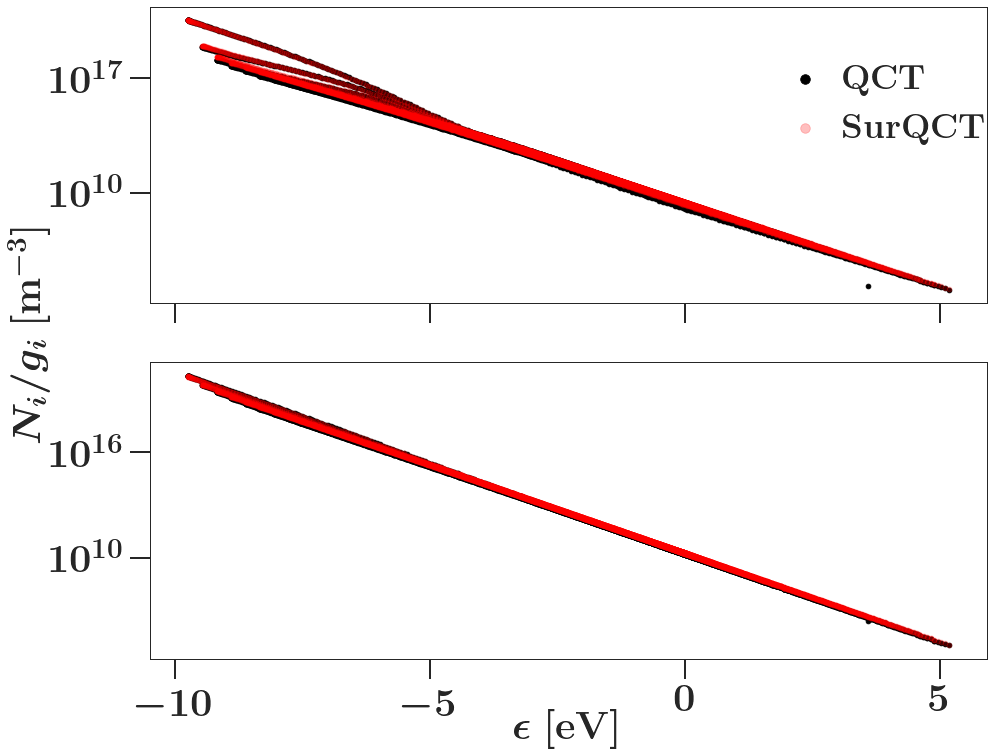

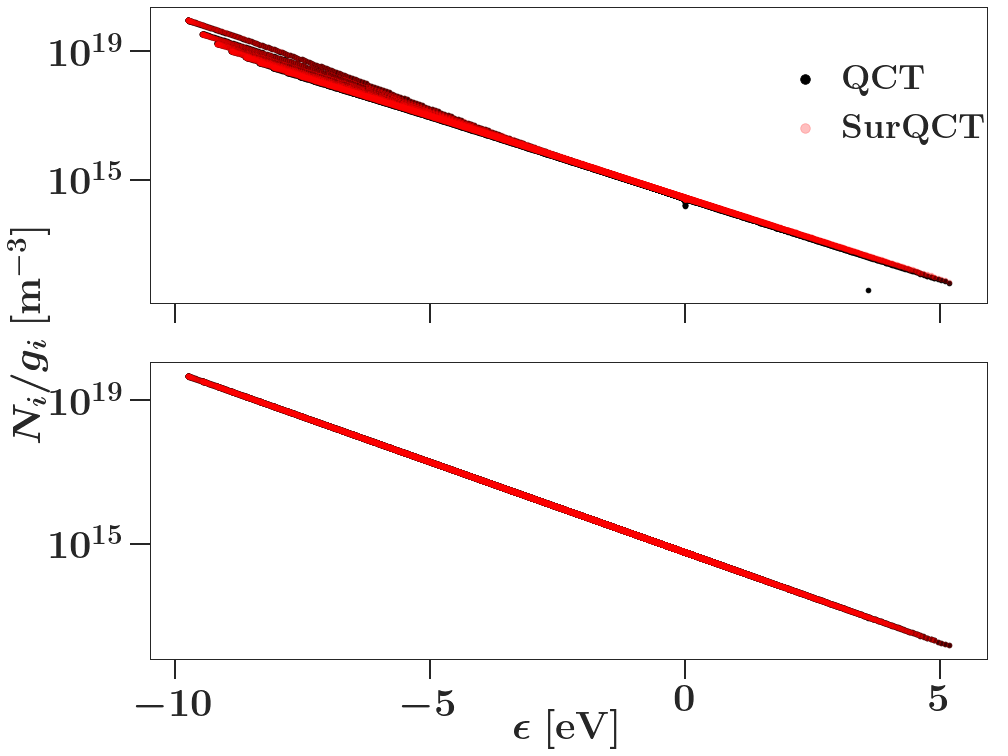

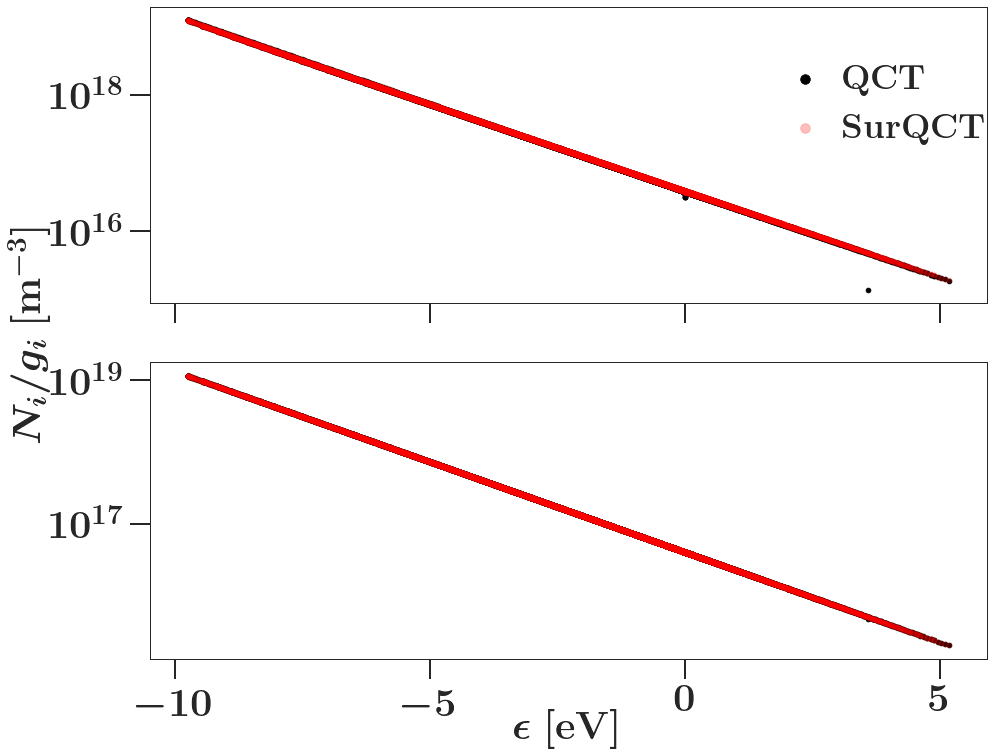

In [30]:
# from Plots import Plot_Populations, Plot_Populations_vcolor, Plot_Populations_ecbcolor 
plot_times=[2e-6,3e-5]
QSSFlg=False
TransVec = [5000,10000,20000]
fig=Plot_Populations(TransVec,plot_times,QSSFlg,QCT,SurQCT)                                                                                                      
# plt.savefig((Paths.Workspace_path + 'Air_Database/Koner_Pop.pdf'), format='pdf', dpi=300)

# # Plot QSS Distribution
# QSSFlg=True
# plot_times=[3e-6,2.6e-7]
# fig=Plot_Populations(TransVec,plot_times,QSSFlg,QCT,SurQCT) 
# fig=Plot_Populations(TransVec,plot_times,QSSFlg)                                                                                                      

# KD and Tau Plots

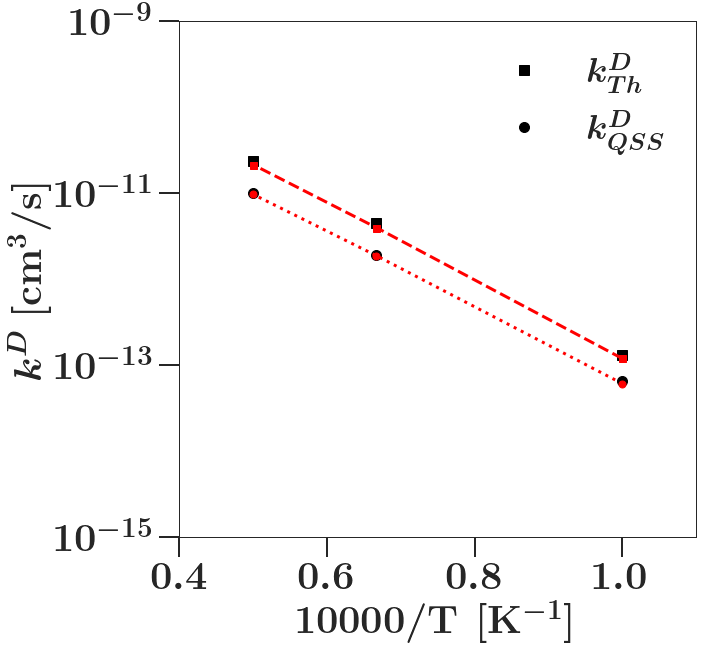

In [7]:
from Plots import Plot_KDth_qss,Plot_taus
fig = Plot_KDth_qss(System, Data_ME_path,ReactionFlgQCT,ReactionFlgSurQCT)
plt.savefig((Figure_ME_path+System.Name+'_'+ReactionFlgSurQCT+'_KD.pdf'), format='pdf', dpi=600)

# fig = Plot_taus(System, Data_ME_path,TauReactionFlgQCT,TauReactionFlgSurQCT)
# plt.savefig((Figure_ME_path+System.Name+'_'+TauReactionFlgSurQCT+'_taus.pdf'), format='pdf', dpi=600)

# Taus for NO-N

In [11]:
def Plot_taus(System,Data_ME_path,ReactionFlgQCT,ReactionFlgSurQCT):                                                                           
                                                                                                                                               
    QCT_tausFile = Data_ME_path+'/QCT_Taus_'+System.Molecule[0].Name+'_'+ReactionFlgQCT+'.csv'                                                 
    QCT_taus = pd.read_csv(QCT_tausFile,header=None,skiprows=1)                                                                                
    QCT_taus.columns = ['Temp','P','tauInt','tauRot','tauVib']                                                                                 
                                                                                                                                               
    SurQCT_tausFile = Data_ME_path+'/DNN_Taus_'+System.Molecule[0].Name+'_'+ReactionFlgSurQCT+'.csv'                                           
    SurQCT_taus = pd.read_csv(SurQCT_tausFile,header=None,skiprows=1)                                                                          
    SurQCT_taus.columns = ['Temp','P','tauInt','tauRot','tauVib']                                                                              
                                                                  
    POF_tausFile = Data_ME_path+'../NO-N/Tau_R-T_Parker_from_myPOF-fit.dat'                                           
    POF_taus = pd.read_csv(POF_tausFile,header=None,skiprows=1)                                                                          
    POF_taus.columns = ['Temp1_3','tauRot'] 
    POF_taus['Temp'] = np.power(POF_taus['Temp1_3'].to_numpy(),-3)
    
    PrevStudy_tausFile = Data_ME_path+'../NO-N/Tau_v-T_PrevStudy.dat'                                           
    PrevStudy_taus = pd.read_csv(PrevStudy_tausFile,header=None,skiprows=1)                                                                          
    PrevStudy_taus.columns = ['Temp1_3','P','tauVibMW','tauVibKim','tauVibPark']  
    PrevStudy_taus['Temp'] = np.power(PrevStudy_taus['Temp1_3'].to_numpy(),-3)
    
    fig,ax = plt.subplots(1,1,figsize=(20,10))                                                                                                 
    plt.plot(QCT_taus.Temp, QCT_taus.tauRot, 'ks', markersize=15, label='$p\\tau_{RT}$, QCT')                                                       
    plt.plot(SurQCT_taus.Temp, SurQCT_taus.tauRot, 'rs', markersize=15, label='$p\\tau_{RT}$, SurQCT')  
    
    plt.plot(QCT_taus.Temp, QCT_taus.tauVib, 'k^', markersize=15, label='$p\\tau_{VT}$, QCT')                                                       
    plt.plot(SurQCT_taus.Temp, SurQCT_taus.tauVib, 'r^' , markersize=15, label='$p\\tau_{VT}$, SurQCT')  
    plt.plot(POF_taus.Temp, POF_taus.tauRot, '--b', markersize=15, label='$p\\tau_{RT}$, Parker (1959)')
    plt.plot(PrevStudy_taus.Temp, PrevStudy_taus.tauVibMW, ':k', markersize=15, label='$p\\tau_{VT}$, MW (1963)')                                                       
    plt.plot(PrevStudy_taus.Temp, PrevStudy_taus.tauVibKim, '-.k' , markersize=15, label='$p\\tau_{VT}$, Kim (2021)') 
#     plt.plot(PrevStudy_taus.Temp, PrevStudy_taus.tauVibPark, '-k' , markersize=15) 
    
    plt.legend(frameon=False, bbox_to_anchor=(1.0, 0.52))                                                                                                                  
    plt.yscale('log')                                                                                                                          
    plt.xlabel('\\textbf{T [K]}')                                                                                                              
    plt.ylabel('$\\tau$ \\textbf{[atm*s]}')                                                                                                    
                                                                                                                                               
    plt.xlim([5000,21000]) 
    plt.ylim([1e-9,1e-7])                                                                                                                      
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')                                                                                   
    fig.tight_layout(pad=2.0)                                                                                                                  
#     plt.xticks([5000,10000,15000,20000])  
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))                                                                               
                                                                                                                                               
    return fig   

In [ ]:
# fig = Plot_taus(System, Data_ME_path,TauReactionFlgQCT,TauReactionFlgSurQCT)
# plt.savefig((Figure_ME_path+System.Name+'_'+TauReactionFlgSurQCT+'_taus.pdf'), format='pdf', dpi=600)

# Taus for N2-N

In [9]:
def Plot_taus(System,Data_ME_path,ReactionFlgQCT,ReactionFlgSurQCT):                                                                           
                                                                                                                                               
    QCT_tausFile = Data_ME_path+'/QCT_Taus_'+System.Molecule[0].Name+'_'+ReactionFlgQCT+'.csv'                                                 
    QCT_taus = pd.read_csv(QCT_tausFile,header=None,skiprows=1)                                                                                
    QCT_taus.columns = ['Temp','P','tauRot','tauVib']                                                                                 
                                                                                                                                               
    SurQCT_tausFile = Data_ME_path+'/DNN_Taus_'+System.Molecule[0].Name+'_'+ReactionFlgSurQCT+'.csv'                                           
    SurQCT_taus = pd.read_csv(SurQCT_tausFile,header=None,skiprows=1)                                                                          
    SurQCT_taus.columns = ['Temp','P','tauRot','tauVib'] 
    
#     SurQCTTrans_tausFile = Transfer_Data_ME_path+'/DNN_Taus_'+System.Molecule[0].Name+'_'+ReactionFlgSurQCT+'.csv'                                           
#     SurQCTTrans_taus = pd.read_csv(SurQCTTrans_tausFile,header=None,skiprows=1)                                                                          
#     SurQCTTrans_taus.columns = ['Temp','P','tauRot','tauVib'] 
    
    
    fig,ax = plt.subplots(1,1,figsize=(10,10))                                                                                                 
    plt.plot(QCT_taus.Temp, QCT_taus.tauRot, 'ks', markersize=15, label='$p\\tau_{RT}$')                                                       
    plt.plot(SurQCT_taus.Temp, SurQCT_taus.tauRot, 'rs', markersize=15)  
#     plt.plot(SurQCTTrans_taus.Temp, SurQCTTrans_taus.tauRot, 'bs' , markersize=15)
    
    plt.plot(QCT_taus.Temp, QCT_taus.tauVib, 'k^', markersize=15, label='$p\\tau_{VT}$')                                                       
    plt.plot(SurQCT_taus.Temp, SurQCT_taus.tauVib, 'r^' , markersize=15)  
#     plt.plot(SurQCTTrans_taus.Temp, SurQCTTrans_taus.tauVib, 'b^' , markersize=15)
    
    plt.legend(frameon=False, bbox_to_anchor=(1.0, 0.52))                                                                                                                  
    plt.yscale('log')                                                                                                                          
    plt.xlabel('\\textbf{T [K]}')                                                                                                              
    plt.ylabel('$\\tau$ \\textbf{[atm*s]}')                                                                                                    
                                                                                                                                               
    plt.xlim([4000,21000]) 
    plt.ylim([1e-9,1e-6])                                                                                                                      
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')                                                                                   
    fig.tight_layout(pad=2.0)                                                                                                                  
#     plt.xticks([5000,10000,15000,20000])  
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))                                                                               
                                                                                                                                               
    return fig   

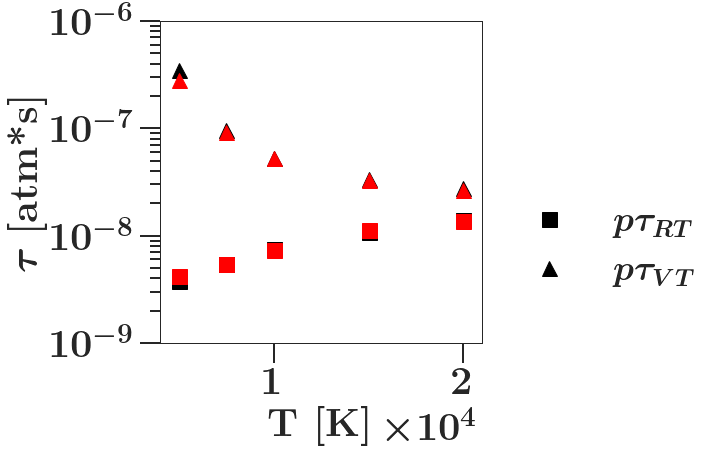

In [10]:
fig = Plot_taus(System, Data_ME_path,TauReactionFlgQCT,TauReactionFlgSurQCT)
# plt.savefig((Figure_ME_path+System.Name+'_'+TauReactionFlgSurQCT+'_taus.pdf'), format='pdf', dpi=600)

In [31]:
def Plot_taus(System,Data_ME_path,ReactionFlgQCT,ReactionFlgSurQCT):                                                                           
                                                                                                                                               
    QCT_tausFile = Data_ME_path+'/QCT_Taus_'+System.Molecule[0].Name+'_'+ReactionFlgQCT+'.csv'                                                 
    QCT_taus = pd.read_csv(QCT_tausFile,header=None,skiprows=1)                                                                                
    QCT_taus.columns = ['Temp','P','tauRot','tauVib']                                                                                 
                                                                                                                                               
    SurQCT_tausFile = Data_ME_path+'/DNN_Taus_'+System.Molecule[0].Name+'_'+ReactionFlgSurQCT+'.csv'                                           
    SurQCT_taus = pd.read_csv(SurQCT_tausFile,header=None,skiprows=1)                                                                          
    SurQCT_taus.columns = ['Temp','P','tauRot','tauVib'] 
    
    Temp_inv = np.power(QCT_taus.Temp,(-1/3))
    SurTemp_inv = np.power(SurQCT_taus.Temp,(-1/3))
    fig,ax = plt.subplots(1,1,figsize=(10,10))                                                                                                 
    plt.plot(Temp_inv, QCT_taus.tauRot, 'ks', markersize=15, label='$p\\tau_{RT}$')                                                       
    plt.plot(SurTemp_inv, SurQCT_taus.tauRot, 'rs', markersize=15)  
    
    plt.plot(Temp_inv, QCT_taus.tauVib, 'k^', markersize=15, label='$p\\tau_{VT}$')                                                       
    plt.plot(SurTemp_inv, SurQCT_taus.tauVib, 'r^' , markersize=15)  
    
    plt.legend(frameon=False)                                                                                                                  
    plt.yscale('log')                                                                                                                          
    plt.xlabel('\\textbf{T}$^{-1/3}$ \\textbf{[K}$^{-1/3}$\\textbf{]}')                                                                                                              
    plt.ylabel('$\\tau$ \\textbf{[atm*s]}')                                                                                                    
                                                                                                                                               
    plt.xlim([0.035,0.08]) 
    plt.ylim([1e-9,3e-6])                                                                                                                      
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')                                                                                   
    fig.tight_layout(pad=2.0)                                                                                                                  
#     plt.xticks([5000,10000,15000,20000])  
#     plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))                                                                               
                                                                                                                                               
    return fig   

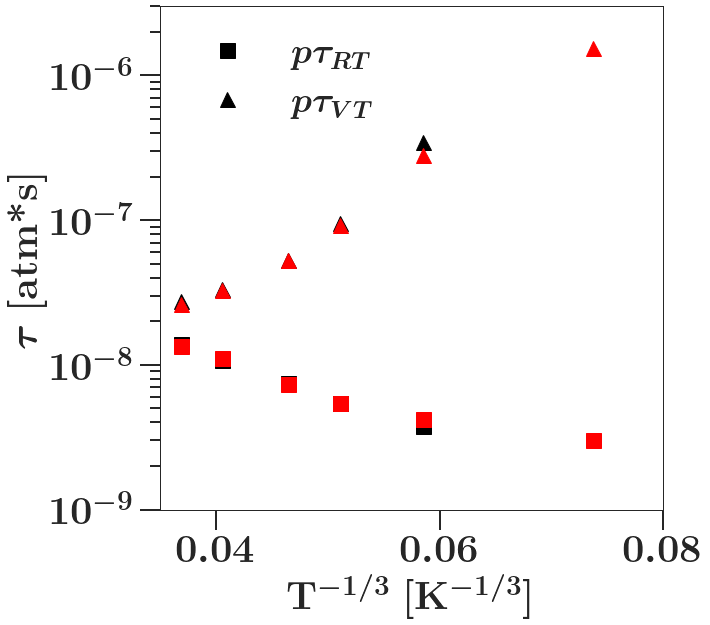

In [33]:
fig = Plot_taus(System, Data_ME_path,TauReactionFlgQCT,TauReactionFlgSurQCT)
plt.savefig((Figure_ME_path+System.Name+'_'+TauReactionFlgSurQCT+'_taus.pdf'), format='pdf', dpi=600)

In [27]:
2500**(-1/3)

0.07368062997280775